In [1]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

from mockfactory import Catalog, utils
from pypower import BaseMatrix, CatalogFFTPower, PowerSpectrumStatistics, CatalogSmoothWindow, PowerSpectrumSmoothWindow, PowerSpectrumSmoothWindowMatrix, setup_logging
sys.path.append('../bin')
from wmatrix_utils import plot_matrix
from power_spectrum import naming

plt.style.use(os.path.join(os.path.abspath(''), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

In [2]:
masked = True
highres = True

In [3]:
tracer = 'ELG_LOP'
completeness = "complete_"
region = 'SGC' #if masked else 'GCcomb'
rp_cut = 2.5
direct = rp_cut

### Pk computed on second gen cutsky mocks

In [4]:
ells = (0, 2, 4)

In [5]:
data_dir = '/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/pk'
power_cutsky_list = []
nmocks = 11

for imock in range(0, nmocks):
    data_fn = naming(filetype='power', data_type='{}Y1secondgenmocks'.format('' if masked else 'raw'), imock=imock, tracer=tracer, completeness=completeness, region=region, rpcut=rp_cut, direct_edges=direct, highres=highres)
    power_cutsky = PowerSpectrumStatistics.load(os.path.join(data_dir, data_fn))(ell=ells, complex=False) #CatalogFFTPower.load(os.path.join(data_dir, data_fn)).poles(ell=ells, complex=False)
    power_cutsky_list.append(power_cutsky)
k_cutsky = PowerSpectrumStatistics.load(os.path.join(data_dir, data_fn)).k #CatalogFFTPower.load(os.path.join(data_dir, data_fn)).poles.k
mean_cutsky = np.mean(power_cutsky_list, axis=0)
std_cutsky = np.std(power_cutsky_list, axis=0)

In [6]:
cutsky_shotnoise_list = list()

for imock in range(0, nmocks):
    data_fn = naming(filetype='power', data_type='{}Y1secondgenmocks'.format('' if masked else 'raw'), imock=imock, tracer=tracer, completeness=completeness, region=region, rpcut=rp_cut, direct_edges=direct, highres=highres)
    #cutsky_shotnoise_list.append(CatalogFFTPower.load(os.path.join(data_dir, data_fn)).poles.shotnoise)
    cutsky_shotnoise_list.append(PowerSpectrumStatistics.load(os.path.join(data_dir, data_fn)).shotnoise)
    
mean_cutsky_shotnoise = np.mean(cutsky_shotnoise_list)
print(mean_cutsky_shotnoise)

1548.7916971222198


In [7]:
#CatalogFFTPower.load(os.path.join(data_dir, data_fn)).poles.attrs

In [8]:
# Nyquist frequency for raw mocks lowres (GCcomb)
np.pi * 1572 / 9432.

0.5235987755982988

In [9]:
# Nyquist frequency for raw mocks highres
np.pi * 2076 / 8304.

0.7853981633974483

In [10]:
# Nyquist frequency for masked highres
np.pi * 2072 / 8288.

0.7853981633974483

In [11]:
# Nyquist frequency for masked lowres
np.pi * 1382 / 8292.

0.5235987755982988

### Pk computed on second gen cubic mocks

In [12]:
data_dir = '/global/cfs/cdirs/desi/users/mpinon/cubicSecondGenMocks/pk'
power_cubic_list = []

for imock in range(0, 25):
    for los in 'xyz':
        data_fn = naming(filetype='power', data_type='cubicsecondgenmocks', imock=imock, tracer=tracer[:3], completeness=completeness, region=region, rpcut=0, direct_edges=False, los=los, highres=highres)
        power_cubic = CatalogFFTPower.load(os.path.join(data_dir, data_fn)).poles(ell=ells, complex=False)
        power_cubic_list.append(power_cubic)
k_cubic = CatalogFFTPower.load(os.path.join(data_dir, data_fn)).poles.k
mean_cubic = np.mean(power_cubic_list, axis=0)
std_cubic = np.std(power_cubic_list, axis=0)

In [13]:
data_dir = '/global/cfs/cdirs/desi/users/mpinon/cubicSecondGenMocks/pk'
shotnoise_list = list()

for imock in range(0, 25):
    data_fn = naming(filetype='power', data_type='cubicsecondgenmocks', imock=imock, tracer=tracer[:3], completeness=completeness, region=region, rpcut=0, direct_edges=False, los=los, highres=highres)
    shotnoise_list.append(CatalogFFTPower.load(os.path.join(data_dir, data_fn)).poles.shotnoise)
    
mean_shotnoise = np.mean(shotnoise_list)

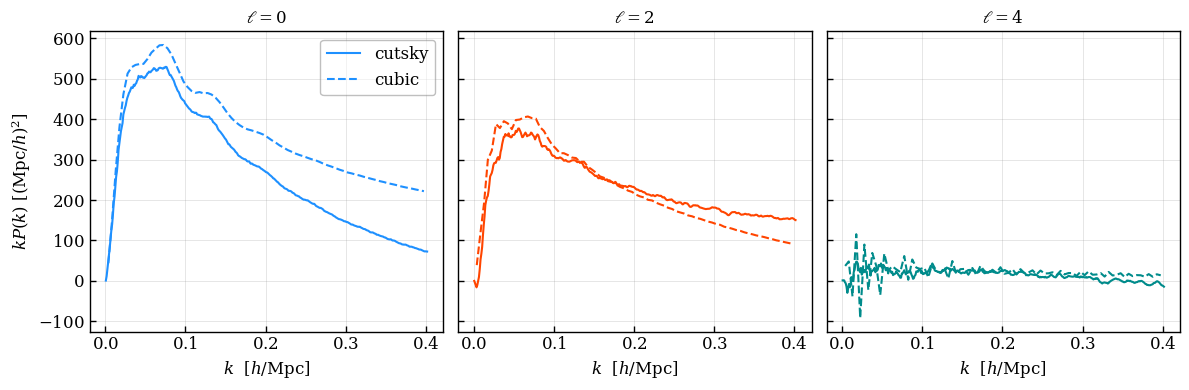

In [14]:
colors=['dodgerblue', 'orangered', 'darkcyan']

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

mask = k_cubic < np.max(k_cutsky)

for i, ell in enumerate(ells):
    axes[i].plot(k_cutsky, k_cutsky * mean_cutsky[i], color=colors[i], ls='-')
    axes[i].plot(k_cubic[mask], k_cubic[mask] * mean_cubic[i][mask], color=colors[i], ls='--')
    axes[i].set_title(r'$\ell={}$'.format(ell))

axes[0].plot([], [], ls='-', color='dodgerblue', label='cutsky')
axes[0].plot([], [], ls='--', color='dodgerblue', label='cubic')
axes[0].legend()
axes[0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
for i in range(len(ells)):
    axes[i].set_xlabel(r'$k$  [$h$/Mpc]')
plt.tight_layout(pad=0.3)

plt.savefig(os.path.join(plots_dir, 'secondgenmocks_cubic_cutsky{}.png'.format('_rpcut{}'.format(rp_cut) if rp_cut else '')), dpi=300)
plt.show()

## Window matrix

In [15]:
window_dir = '/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/windows/'+('old' if not highres else '')
wm_fn = naming(filetype='wm', data_type='{}Y1secondgenmocks'.format('' if masked else 'raw'), imock=None if masked else 0, tracer=tracer, completeness=completeness, region=region, rpcut=rp_cut, direct_edges=direct)
wm = BaseMatrix.load(os.path.join(window_dir, wm_fn.format('_minboxsize1000' if not masked else '')))

In [16]:
#plot_matrix(wm.unpacked(), x1=wm.xin, x2=wm.xout, xlabel1=r'$k^\prime$ [$h/\mathrm{Mpc}$]', xlabel2=r'$k$ [$h/\mathrm{Mpc}$]',
#            barlabel=None, label1=[proj.latex(inline=True) for proj in wm.projsin], label2=[proj.latex(inline=True) for proj in wm.projsout],
#            figsize=(6, 6));
#plt.show()

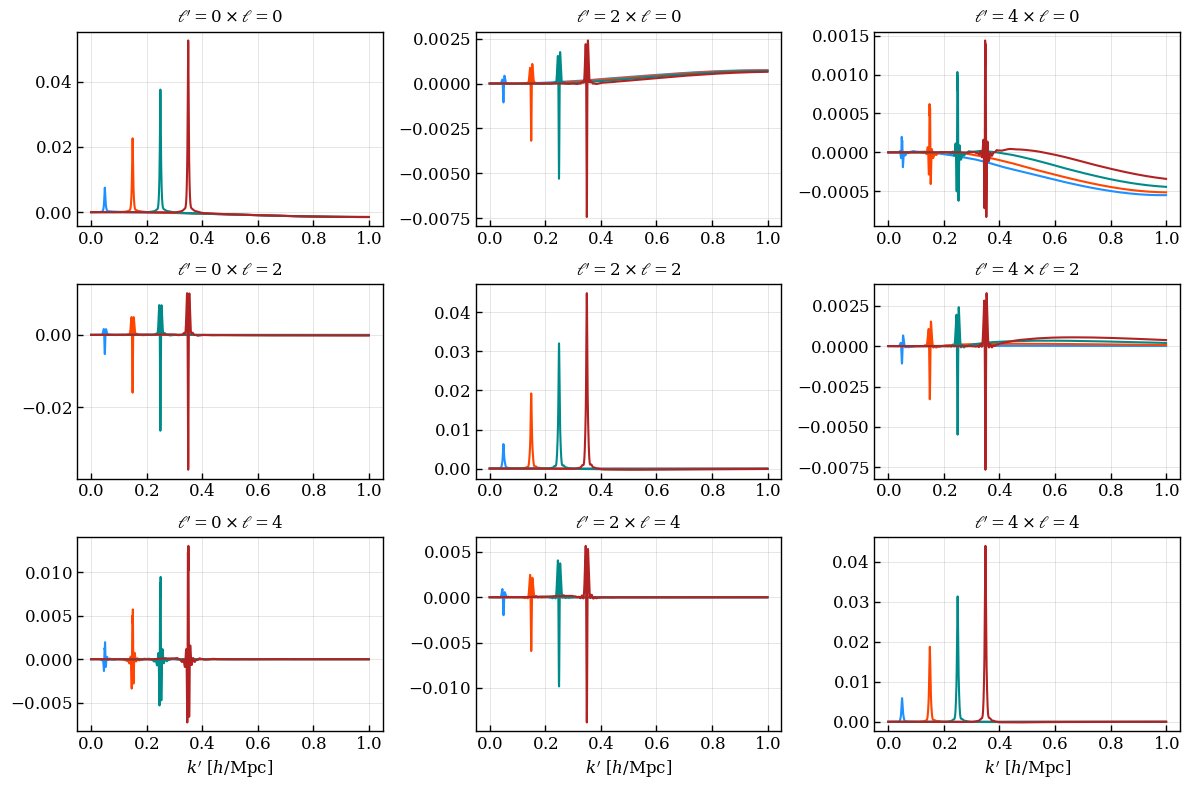

In [17]:
indexouts = [np.abs(wm.xout[0] - kout).argmin() for kout in [0.05, 0.15, 0.25, 0.35]]
a = wm.unpacked()

fig, lax = plt.subplots(len(wm.projsout), len(wm.projsin), figsize=(12, 8))
for iin, projin in enumerate(wm.projsin):
    for iout, projout in enumerate(wm.projsout):
        ax = lax[iout][iin]
        # Indices in approximative window matrix
        norm = 1.
        for indexout in indexouts:
            ax.plot(wm.xin[iin], a[iin][iout][:, indexout] / norm)
        ax.set_title(r'$\ell^\prime = {:d} \times \ell = {:d}$'.format(projin.ell, projout.ell))
        ax.grid(True)
        if iout == len(wm.projsout) - 1: ax.set_xlabel(r'$k^\prime$ [$h/\mathrm{Mpc}$]')

In [18]:
wm.select_x(xinlim=(np.min(k_cubic), np.max(k_cubic)))

In [19]:
wm.select_x(xinlim=(0.005, 0.35))

In [21]:
wm.xin[0]

array([0.00500099, 0.00500633, 0.00501168, ..., 0.3492014 , 0.34957471,
       0.34994841])

In [22]:
power_diff_list = []

for imock in range(0, nmocks):
    power_cutsky = power_cutsky_list[imock]

    for los in 'xyz':
        data_fn = naming(filetype='power', data_type='cubicsecondgenmocks', imock=imock, tracer=tracer[:3], completeness=completeness, region=region, rpcut=0, direct_edges=False, los=los, highres=highres)
        power_cubic_los = CatalogFFTPower.load(os.path.join(data_dir, data_fn)).poles(ell=ells, complex=False)
        #power_cubic_los[0] += mean_shotnoise
        power_cubic_list.append(power_cubic_los)
    power_cubic = np.mean(power_cubic_list, axis=0)
    power_cubic_interp = interp1d(k_cubic, power_cubic)(wm.xin[0])
    power_diff = wm.value.T.dot(power_cubic_interp.flatten()) - power_cutsky.flatten()
    tmp = power_diff.reshape((len(ells), wm.shape[1]//len(ells)))
    #tmp[0] = tmp[0] - mean_shotnoise
    power_diff_list.append(tmp)

mean_diff = np.mean(power_diff_list, axis=0)
std_diff = np.std(power_diff_list, axis=0)

In [23]:
mean_cubic_shotnoise = mean_cubic.copy()
#mean_cubic_shotnoise[0] += mean_shotnoise
mean_cubic_interp = interp1d(k_cubic, mean_cubic_shotnoise)(wm.xin[0])

In [24]:
k = wm.xout[0]

In [25]:
wm_pk = wm.value.T.dot(mean_cubic_interp.flatten()).reshape((len(ells), wm.shape[1]//len(ells)))
#wm_pk[0] -= mean_shotnoise

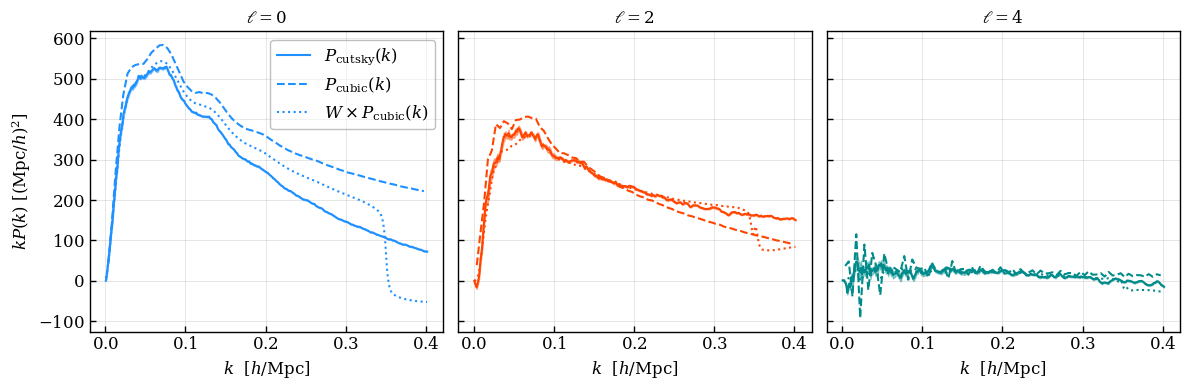

In [27]:
ells = (0, 2, 4)
colors=['dodgerblue', 'orangered', 'darkcyan']

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, ell in enumerate(ells):
    axes[i].plot(k_cutsky, k_cutsky * mean_cutsky[i], color=colors[i], ls='-')
    axes[i].plot(k_cubic[mask], k_cubic[mask] * mean_cubic[i][mask], color=colors[i], ls='--')
    axes[i].plot(k, k * wm_pk[i], color=colors[i], ls=':')
    axes[i].set_title(r'$\ell={}$'.format(ell))
    axes[i].fill_between(k_cutsky, k_cutsky * (mean_cutsky[i] - std_cutsky[i]/5.), k_cutsky * (mean_cutsky[i] + std_cutsky[i]/5.), alpha=0.4, color=colors[i])
    
axes[0].plot([], [], ls='-', color='dodgerblue', label=r'$P_{\mathrm{cutsky}}(k)$')
axes[0].plot([], [], ls='--', color='dodgerblue', label=r'$P_{\mathrm{cubic}}(k)$')
axes[0].plot([], [], ls=':', color='dodgerblue', label=r'$W \times P_{\mathrm{cubic}}(k)$')
axes[0].legend()
axes[0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
for i in range(len(ells)):
    axes[i].set_xlabel(r'$k$  [$h$/Mpc]')
plt.tight_layout(pad=0.3)
plt.savefig(os.path.join(plots_dir, 'secondgenmocks_cubic_cutsky_window{}_ktmax0.35.png'.format('_rpcut{}'.format(rp_cut) if rp_cut else '')), dpi=300)
plt.show()

In [35]:
#wm_pk_interp = interp1d(k, wm_pk)(k_cutsky)

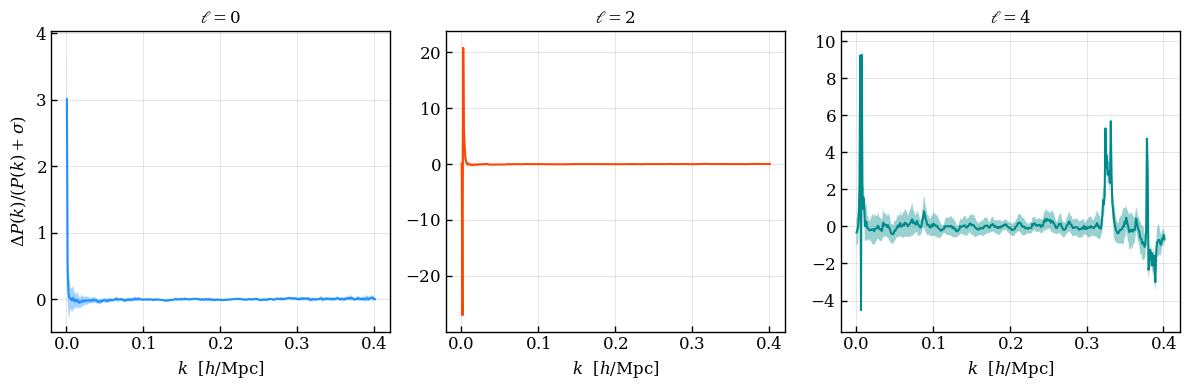

In [36]:
ells = (0, 2, 4)
colors=['dodgerblue', 'orangered', 'darkcyan']

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)

for i, ell in enumerate(ells):
    residual = (wm_pk[i] - mean_cutsky[i]) / (mean_cutsky[i] + std_diff[i])
    axes[i].plot(k_cutsky, residual, color=colors[i], ls='-')
    axes[i].set_title(r'$\ell={}$'.format(ell))
    axes[i].fill_between(k_cutsky, residual - std_diff[i]/(np.abs(mean_cutsky[i]) + std_diff[i]), residual + std_diff[i]/(np.abs(mean_cutsky[i]) + std_diff[i]), facecolor=colors[i], alpha=0.4)

axes[0].set_ylabel(r'$\Delta P(k) / (P(k) + \sigma)$')
for i in range(len(ells)):
    axes[i].set_xlabel(r'$k$  [$h$/Mpc]')
plt.tight_layout(pad=0.3)
#plt.savefig(os.path.join(plots_dir, 'secondgenmocks_cubic_cutsky_window_residuals{}.png'.format('_rpcut{}'.format(rp_cut) if rp_cut else '')), dpi=300)
plt.show()

## Y1 covariances

In [37]:
covdir = '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/blinded/pk/covariances/'
c1 = np.loadtxt(os.path.join(covdir, 'cov_gaussian_prerec_ELG_LOPnotqso_GCcomb_0.8_1.1.txt'))
c2 = np.loadtxt(os.path.join(covdir, 'cov_gaussian_prerec_ELG_LOPnotqso_GCcomb_1.1_1.6.txt'))
cov = np.linalg.inv(np.linalg.inv(c1) + np.linalg.inv(c2))

In [38]:
from scipy.interpolate import interp1d
stdY1 = interp1d(np.array((np.arange(0, 0.4, 0.005), )*3).flatten(), np.sqrt(np.diag(cov)), bounds_error=False)(np.array((k_cutsky, )*3)).reshape(mean_cutsky.shape)

In [39]:
wm.xin[0]

array([0.00380016, 0.00380422, 0.00380829, ..., 0.99711406, 0.99817999,
       0.99924707])

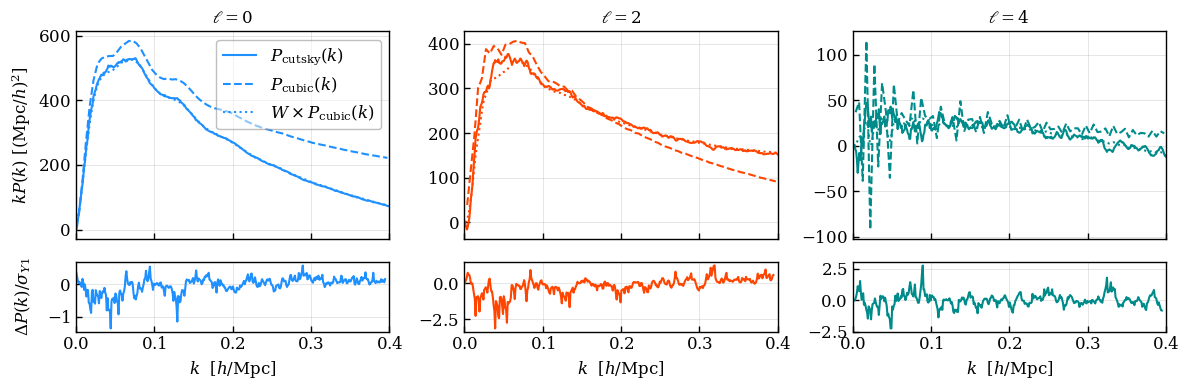

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(12, 4), sharey=False, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

for i, ell in enumerate(ells):
    axes[0][i].plot(k_cutsky, k_cutsky * mean_cutsky[i], color=colors[i], ls='-')
    axes[0][i].plot(k_cubic[mask], k_cubic[mask] * mean_cubic[i][mask], color=colors[i], ls='--')
    axes[0][i].plot(k, k * wm_pk[i], color=colors[i], ls=':')
    axes[0][i].set_title(r'$\ell={}$'.format(ell))
       
    scale = 1
    norm = stdY1[i] #(np.abs(mean_cutsky[i]) + std_diff[i]/scale)
    residual = (wm_pk[i] - mean_cutsky[i]) 
    axes[1][i].plot(k_cutsky, residual/norm, color=colors[i], ls='-')
    #axes[1][i].fill_between(k_cutsky, (residual - stdY1[i]/scale)/norm, (residual + stdY1[i]/scale)/norm, facecolor='grey', alpha=0.4)
    #axes[1][i].fill_between(k_cutsky, (residual - std_diff[i]/scale)/norm, (residual + std_diff[i]/scale)/norm, facecolor=colors[i], alpha=0.2)
    axes[1][i].set_xlim((0, 0.4))
    #if i < 2:
    #    axes[1][i].set_ylim((-0.1, 0.1))
    
axes[0][0].plot([], [], ls='-', color='dodgerblue', label=r'$P_{\mathrm{cutsky}}(k)$')
axes[0][0].plot([], [], ls='--', color='dodgerblue', label=r'$P_{\mathrm{cubic}}(k)$')
axes[0][0].plot([], [], ls=':', color='dodgerblue', label=r'$W \times P_{\mathrm{cubic}}(k)$')
#axes[1][0].plot([], [], ls='-', color='dodgerblue', label=r'(window x cubic - cutsky) / $\sigma$')
axes[0][0].legend()
#axes[1][0].legend()
axes[0][0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
#axes[1][0].set_ylabel(r'$\Delta P(k) / (P(k) + \sigma)$')
axes[1][0].set_ylabel(r'$\Delta P(k) / \sigma_{Y1}$')

for i in range(len(ells)):
    axes[1][i].set_xlabel(r'$k$  [$h$/Mpc]')
    
fig.align_ylabels()
#plt.savefig(os.path.join(plots_dir, 'secondgenmocks_cubic_{}cutsky_window_withresiduals{}{}.png'.format('masked' if masked else 'raw', '_rpcut{}'.format(rp_cut) if rp_cut else '', '_highres' if highres else '')), dpi=300)

In [30]:
mask = np.logical_and(k > 0.004, k < 0.395)
kmask = k[mask]

def model(shotnoise, cutsky_shotnoise=mean_cutsky_shotnoise):
    mean_cubic_shotnoise = mean_cubic.copy()
    mean_cubic_shotnoise[0] += shotnoise
    mean_cubic_interp = interp1d(k_cubic, mean_cubic_shotnoise)(wm.xin[0])
    wm_pk = wm.value.T.dot(mean_cubic_interp.flatten()).reshape((len(ells), wm.shape[1]//len(ells)))
    wm_pk[0] -= cutsky_shotnoise
    return wm_pk[0][mask]

def chi2(shotnoise):
    r = model(shotnoise) - mean_cutsky[0][mask]
    chisq = np.sum(r**2 / stdY1[0][mask]**2)
    return chisq

In [31]:
from scipy.optimize import minimize

minimizer = minimize(chi2, x0=0)
print(minimizer)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 130153.57180276347
        x: [-1.123e+03]
      nit: 7
      jac: [ 0.000e+00]
 hess_inv: [[ 1.030e+04]]
     nfev: 34
     njev: 17


In [32]:
sn = minimizer.x

In [33]:
sn

array([-1122.95621266])

In [34]:
mean_shotnoise

476.3260510761793

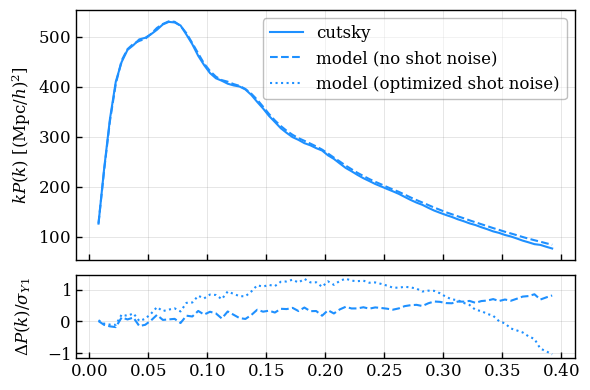

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharey=False, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

axes[0].plot(kmask, kmask * mean_cutsky[0][mask], color='dodgerblue', ls='-')
axes[0].plot(kmask, kmask * model(0, 0), color='dodgerblue', ls='--')
#axes[0].plot(kmask, kmask * model(0), color='dodgerblue', ls=':')
#axes[0].plot(kmask, kmask * model(mean_shotnoise, mean_shotnoise), color='dodgerblue', ls='-.')

norm = stdY1[0][mask]
residual = (model(0, 0) - mean_cutsky[0][mask]) 
axes[1].plot(kmask, residual/norm, color='dodgerblue', ls='--')
residual = (model(sn, 0) - mean_cutsky[0][mask]) 
axes[1].plot(kmask, residual/norm, color='dodgerblue', ls=':')
#residual = (model(mean_shotnoise, mean_shotnoise) - mean_cutsky[0][mask]) 
#axes[1].plot(kmask, residual/norm, color='dodgerblue', ls='-.')
    
axes[0].plot([], [], ls='-', color='dodgerblue', label='cutsky')
axes[0].plot([], [], ls='--', color='dodgerblue', label='model (no shot noise)')
axes[0].plot([], [], ls=':', color='dodgerblue', label='model (optimized shot noise)')
#axes[0].plot([], [], ls='-.', color='dodgerblue', label='model (cubic shot noise)')
axes[0].legend()
axes[0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1].set_ylabel(r'$\Delta P(k) / \sigma_{Y1}$')

fig.align_ylabels()
plt.savefig(os.path.join(plots_dir, 'secondgenmocks_cubic_{}cutsky_window_withresiduals{}{}_shotnoisetests.png'.format('masked' if masked else 'raw', '_rpcut{}'.format(rp_cut) if rp_cut else '', '_highres' if highres else '')), dpi=300)

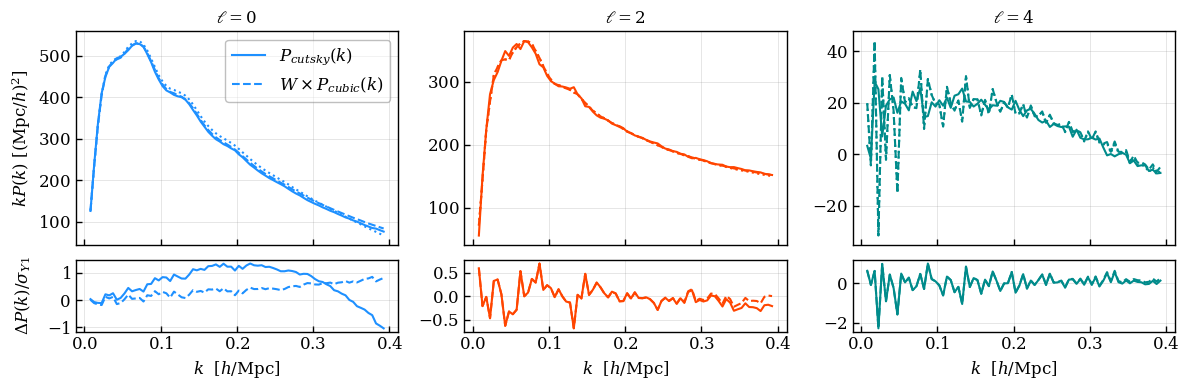

In [36]:
mean_cubic_shotnoise = mean_cubic.copy()
mean_cubic_shotnoise[0] += sn
mean_cubic_interp = interp1d(k_cubic, mean_cubic_shotnoise)(wm.xin[0])
wm_pk = wm.value.T.dot(mean_cubic_interp.flatten()).reshape((len(ells), wm.shape[1]//len(ells)))
#wm_pk[0] -= mean_cutsky_shotnoise

mean_cubic_interp_sn0 = interp1d(k_cubic, mean_cubic)(wm.xin[0])
wm_pk_sn0 = wm.value.T.dot(mean_cubic_interp_sn0.flatten()).reshape((len(ells), wm.shape[1]//len(ells)))

fig, axes = plt.subplots(2, 3, figsize=(12, 4), sharey=False, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

for i, ell in enumerate(ells):
    axes[0][i].plot(kmask, kmask * mean_cutsky[i][mask], color=colors[i], ls='-')
    axes[0][i].plot(kmask, kmask * wm_pk_sn0[i][mask], color=colors[i], ls='--')
    axes[0][i].plot(kmask, kmask * wm_pk[i][mask], color=colors[i], ls=':')
    axes[0][i].set_title(r'$\ell={}$'.format(ell))
       
    norm = stdY1[i][mask]
    residual = (wm_pk_sn0[i][mask] - mean_cutsky[i][mask]) 
    axes[1][i].plot(kmask, residual/norm, color=colors[i], ls='--')
    residual = (wm_pk[i][mask] - mean_cutsky[i][mask]) 
    axes[1][i].plot(kmask, residual/norm, color=colors[i], ls='-')
    
axes[0][0].plot([], [], ls='-', color='dodgerblue', label=r'$P_{cutsky}(k)$')
axes[0][0].plot([], [], ls='--', color='dodgerblue', label=r'$W \times P_{cubic}(k)$')
#axes[0][0].plot([], [], ls=':', color='dodgerblue', label=r'$W \times P_{cubic}(k)$')
axes[0][0].legend()
axes[0][0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$\Delta P(k) / \sigma_{Y1}$')

for i in range(len(ells)):
    axes[1][i].set_xlabel(r'$k$  [$h$/Mpc]')
    
fig.align_ylabels()
plt.savefig(os.path.join(plots_dir, 'secondgenmocks_cubic_{}cutsky_window_withresiduals{}{}_optshotnoise.png'.format('masked' if masked else 'raw', '_rpcut{}'.format(rp_cut) if rp_cut else '', '_highres' if highres else '')), dpi=300)